In [1]:
import skimage.io as skio
import skimage
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import numpy as np
from bench_filter import Bench_Filter
from sklearn.model_selection import train_test_split
import random
import skimage.morphology as skm
from tools import *

In [2]:
from multiprocessing import cpu_count
cpus = cpu_count()
print(f'Number of CPU cores available : {cpus}')

Number of CPU cores available : 4


In [3]:
DATASET = ['Fluo-N2DL-HeLa','PhC-C2DH-U373']
idx = 1

IM_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TRAIN/*.tif'))
TG_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TRAIN/*.tif'))

In [4]:
X_train, y_train = load_img_tg(IM_PATH, TG_PATH)
len(X_train)

184

In [21]:
X_train_cropped, y_train_cropped = [], []
#dimension of patchs = M*N
ratio = 4
M = X_train[0].shape[0]//ratio
N = X_train[0].shape[1]//ratio
print(f'Taille des patchs : ({M},{N})')
for k in range(len(X_train)):
    im = X_train[k]
    tg = y_train[k]
    im_tiles = [im[x:x+M, y:y+N] for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)]
    tg_tiles = [tg[x:x+M, y:y+N] for x in range(0, im.shape[0], M) for y in range(0, im.shape[1], N)]
    scores = []
    for i in range(len(im_tiles)):
        scores.append(np.sum(tg_tiles[i]))
    idx_best_score = np.argmax(scores)
    X_train_cropped.append(im_tiles[idx_best_score])
    y_train_cropped.append(tg_tiles[idx_best_score])

Taille des patchs : (130,174)


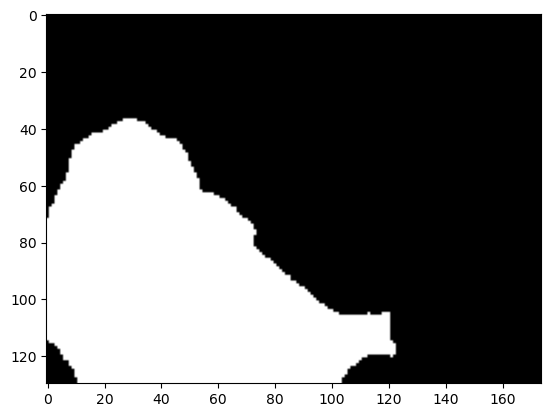

In [22]:
plt.imshow(y_train_cropped[60], cmap='gray')

In [23]:
BF = Bench_Filter(n_estimators=9, cpus=cpus-1) #Leave 1 cpu to avoid computer crash
BF.add_identity()
BF.add_gaussian(np.sqrt(2)/2)
BF.add_gaussian(np.sqrt(2))
BF.add_gaussian(np.sqrt(2)*2) #Progression en sqrt(2)
BF.add_median(skm.disk(3))
BF.add_median()
BF.add_sobel()
BF.add_farid()
BF.add_prewitt()
BF.add_roberts()
BF.add_scharr()

In [24]:
BF.fit(X_train_cropped, y_train_cropped)

Applying filters to dataset: 184it [00:04, 40.21it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 9
building tree 2 of 9
building tree 3 of 9
building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:  2.8min finished


In [25]:
IM_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/IMG_TEST/*.tif'))
TG_TEST_PATH = sorted(glob.glob(f'data/{DATASET[idx]}/TARGET_TEST/*.tif'))

X_test, y_test = load_img_tg(IM_TEST_PATH, TG_TEST_PATH)

In [26]:
y_pred = BF.predict(X_test)

Applying filters to dataset: 46it [00:13,  3.47it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   31.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   31.2s finished


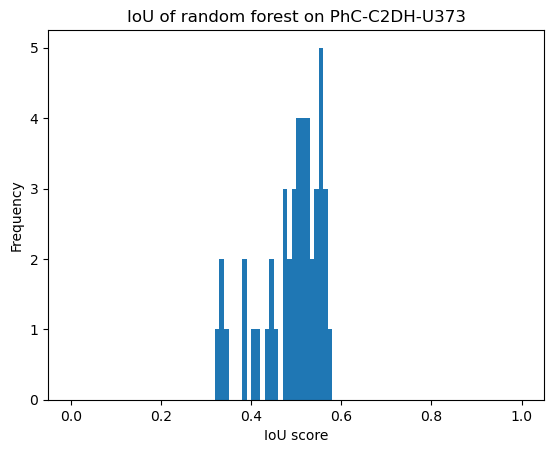

In [27]:
results = []
for i, pred in enumerate(y_pred):
    results.append(jaccard_score(y_test[i],pred,average='micro'))
plt.hist(results,bins=100,range=(0,1))
plt.title(f'IoU of random forest on {DATASET[idx]}')
plt.xlabel('IoU score')
plt.ylabel('Frequency')
plt.savefig(f'output/rf_crop_performance_dataset_{idx}.png')

Applying filters to dataset: 1it [00:00,  3.03it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    1.0s finished


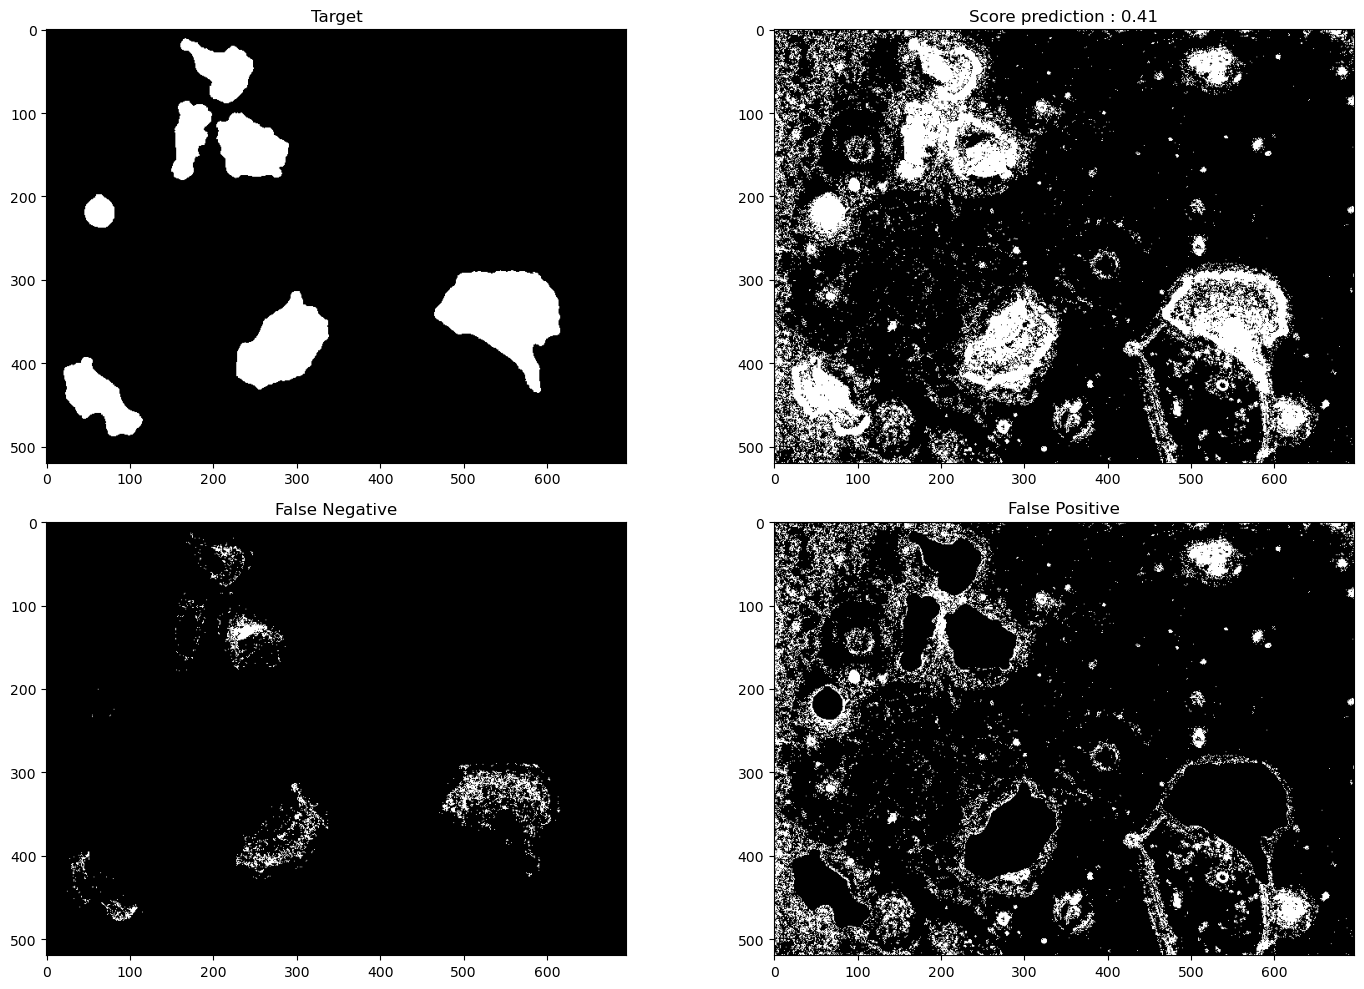

In [28]:
n_im = random.randrange(len(y_test))
target = y_test[n_im]
seg = skimage.img_as_bool(BF.predict([X_test[n_im]])[0])
score = jaccard_score(target,seg,average='micro')

fig = plot_pred_with_target(target,seg,score)
fig.savefig(f'output/inference_rf_crop_dataset_{idx}.png')

Applying filters to dataset: 1it [00:00,  3.19it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished
Applying filters to dataset: 1it [00:00,  3.17it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished
Applying filters to dataset: 1it [00:00,  3.20it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished
Applying filters to dataset: 1it [00:00,  2.69it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: 

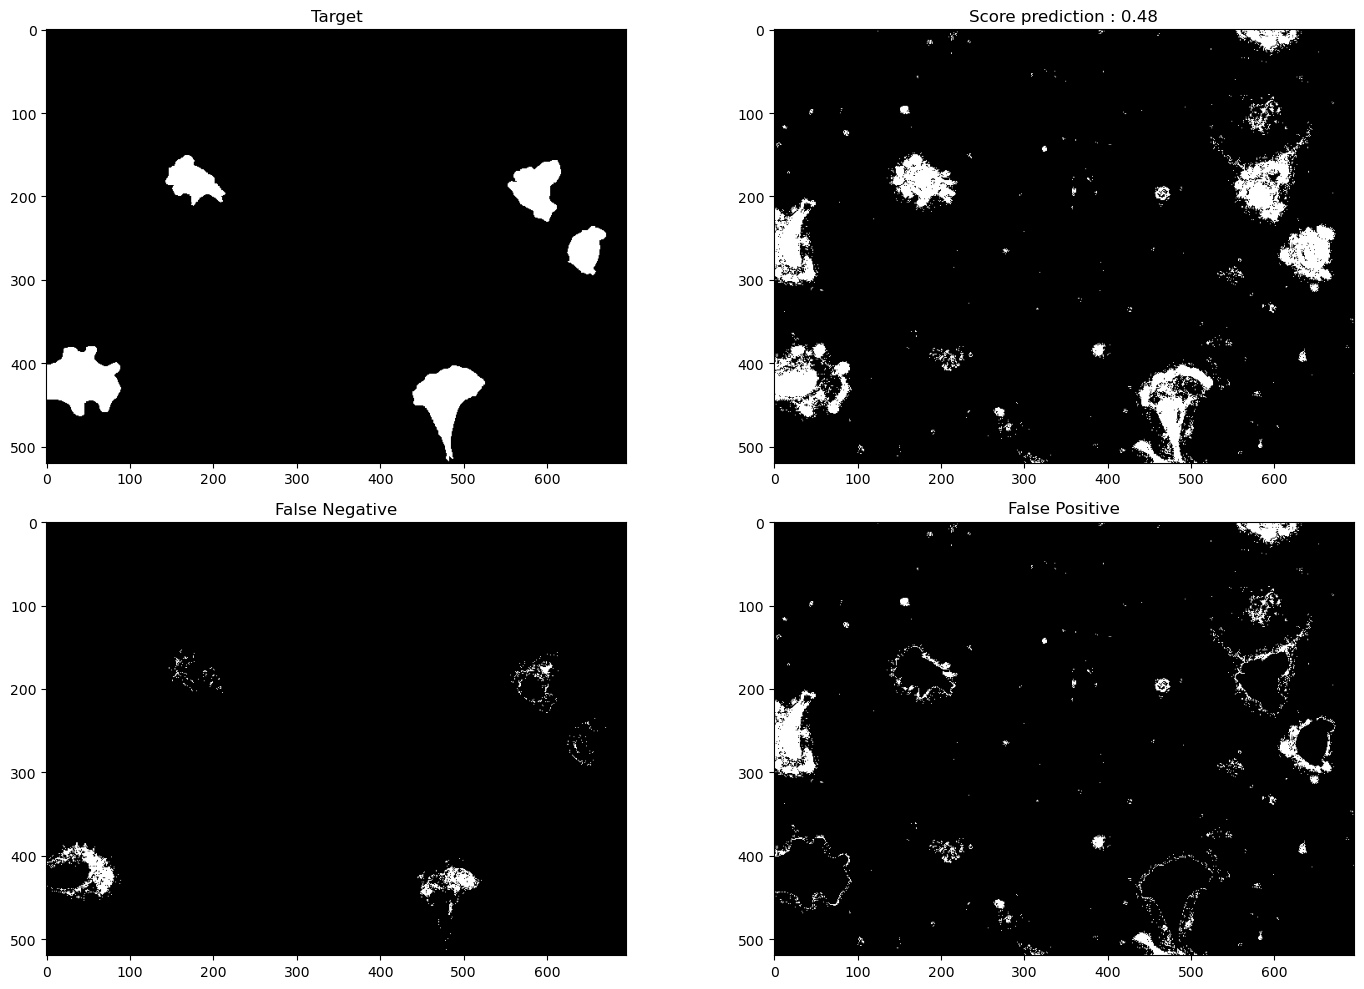

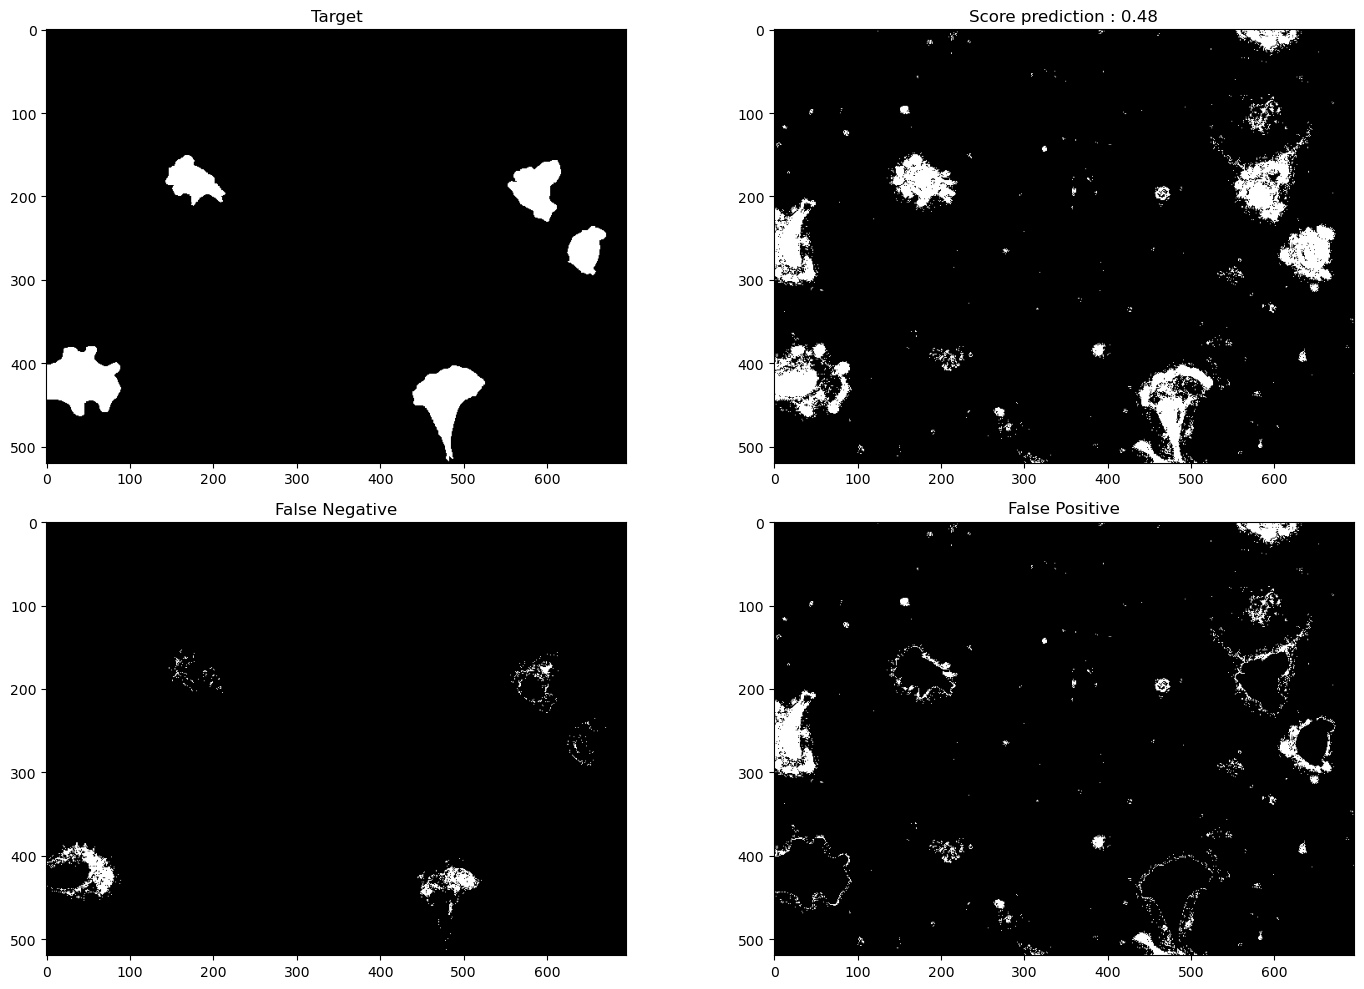

In [14]:
score = 1
n_im = 0
while score > 0.5 and n_im < len(y_test) :
    target = y_test[n_im]
    seg = skimage.img_as_bool(BF.predict([X_test[n_im]])[0])
    score = jaccard_score(target,seg,average='micro')
    n_im += 1
    
plot_pred_with_target(target,seg,score)
    